# Assignment-4: Apply Naive Bayes on Amazon reviews 

## Introduction

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

Naive Bayes model is easy to build and particularly useful for very large data sets. Along with simplicity, Naive Bayes is known to outperform even highly sophisticated classification methods.

Bayes theorem provides a way of calculating posterior probability P(c|x) from P(c), P(x) and P(x|c). Look at the equation below:



![title](picture.png)

## Objective:
#### To Predict the Polarity of Amazon Fine Food Review Using Naive-Bayes Algorithm

#### Apply Naive Bayes Algorithm on
1. Bow(Bag of Words)
2. TF-IDF

#### Add some feature to the dataset and apply Naive Bayes on new dataset

### [Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review

### Steps :

#### We will perform following steps for classifying the review as positive or Negative:
##### 1.Importing data 
##### 2.Preparing that data
##### 3.Choosing a model
##### 4.Training
##### 5.Evaluation
##### 6.Hyperparameter tuning
##### 7.Prediction.

## Importing Dataset and important libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
from sklearn import metrics

In [3]:
import math
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [4]:
import sqlite3
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from NaiveBayes where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

##### Note:
The file "final.sqlite" contains preprossed data. Preproccessing steps like data cleaning, data deduplication, stemming, lammetizaion and removal of stop words have already been applied to the review text

## Breif Description of Data Set


In [5]:
print("Number of Reviews: ",Data["Text"].count())
print("Number of Users: ",len(Data["UserId"].unique())) 
print("Number of Products: ",len(Data["ProductId"].unique()))
print("Shape of Data: ",Data.shape)
print("\n",Data.columns)
print("Number of Attributes/Columns in data: 12") 
print("Number of Positive Reviews : ", Data['Score'].value_counts()[1])
print("Number of Negative Reviews : ", Data['Score'].value_counts()[0])

Number of Reviews:  150000
Number of Users:  115632
Number of Products:  43130
Shape of Data:  (150000, 12)

 Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')
Number of Attributes/Columns in data: 12
Number of Positive Reviews :  126439
Number of Negative Reviews :  23561


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

#### Due to limited hardware resource I am limiting my analysis to 150000 data points

In [6]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [7]:
Data = Data.sample(n=150000)
Data['Score'].value_counts()

1    126439
0     23561
Name: Score, dtype: int64

In [8]:
X = Data['CleanedText'].values
y = Data['Score'].values
Alpha={'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

## Dividing the Data into Train and test set

In [9]:
#splitting
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size = 0.33)

In [10]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(100500,) (100500,)
(49500,) (49500,)


### Resuable codes

In [11]:
#confusion matrix
def confusionmatrix(model,X,y):
    ob = confusion_matrix(y,model.predict(X))
    label = ['NEGATIVE','POSITIVE']
    df = pd.DataFrame(ob,index=label,columns=label)
    sns.heatmap(df,annot=True,fmt ='d')

In [12]:
#findbestparameter
def findbestparameter(model,X,y):
    tscv = TimeSeriesSplit(n_splits=10)
    gs = GridSearchCV(model,Alpha,scoring='roc_auc',cv=tscv)
    gs.fit(X,y)
    return gs

In [13]:
#auc-curve
def plot_auc(gscv):
    
    results=gscv.cv_results_
    train_auc=results['mean_train_score']
    train_auc_std=results['std_train_score']
    cv_auc=results['mean_test_score']
    cv_auc_std=results['std_test_score']
    
    log_alpha=[math.log10(x) for x in Alpha['alpha'] ]
    plt.plot(log_alpha, train_auc, label='Train AUC')
    plt.gca().fill_between(log_alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.01,color='darkblue')

    plt.plot(log_alpha, cv_auc, label='CV AUC')
    plt.gca().fill_between(log_alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.01,color='darkorange')
    plt.legend()
    plt.xlabel("Log(Alpha): hyperparameter")
    plt.ylabel("AUC")
    plt.title("Plot Between AUC & Log(Alpha)")
    plt.show()

In [1]:
#imporntantfeatures
def important_features(vectorizer,model,n=30):
    
    # For Negative Class
    #Reference : StackOverflow
    neg_class_prob_sorted = model.feature_log_prob_[0, :].argsort()
    neg_feat=[vectorizer.get_feature_names()[x] for x in neg_class_prob_sorted[-n:]]
    neg_prob=[model.feature_log_prob_[0, :][x] for x in neg_class_prob_sorted[-n:]]
    
    neg_zip=list(zip(neg_feat,neg_prob))
    neg_zip.sort()
    
    # For Positive Class 
    pos_class_prob_sorted = model.feature_log_prob_[1, :].argsort()
    pos_feat=[vectorizer.get_feature_names()[x] for x in pos_class_prob_sorted[-n:]]
    pos_prob=[model.feature_log_prob_[0, :][x] for x in pos_class_prob_sorted[-n:]]
    pos_zip=list(zip(pos_feat,pos_prob))
    pos_zip.sort()
    
    top=zip(pos_zip,neg_zip)
    
    print("{0:20}{1:55}{2:20}".format("S.N","Positive","Negative"))
    print("_"*90)
    i=1
    for (fn_1,coef_1), (fn_2,coef_2) in top:
        print("%d.\t\t%.3f\t%-30s\t\t%.3f\t%s" % (i,coef_1, fn_1, coef_2, fn_2))
        i+=1
    

In [15]:
#Plot ROC_AUC Curve

def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

## Bags of Words

#### Vectorization of review text

In [21]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_bow = preprocessing.normalize(vect.transform(X_train))

In [22]:
X_test_bow = preprocessing.normalize(vect.transform(X_test))

In [23]:
#shapes
print(X_train_bow.shape,y_train.shape)
print(X_test_bow.shape,y_test.shape)

(100500, 38391) (100500,)
(49500, 38391) (49500,)


#### Finding the best value of hyperparameter alpha

In [24]:
#select best parameter for multinomialNB
model = MultinomialNB()
gscv = findbestparameter(model,X_train_bow,y_train)

In [25]:
print(gscv.best_params_)
print(gscv.best_score_*100)
math.log10(0.05)

{'alpha': 0.05}
92.23250035319617


-1.3010299956639813

#### Ploting AUC-Log(Alpha) Curve

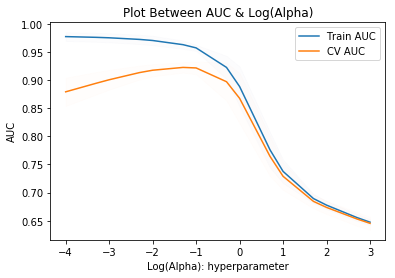

In [26]:
plot_auc(gscv)

#### Training the Model with best parameter

In [27]:
#training the model

model = MultinomialNB(alpha=gscv.best_params_['alpha'])
model.fit(X_train_bow,y_train)

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

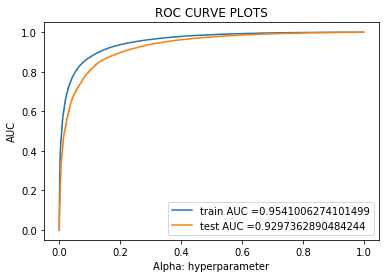

In [38]:
plot_auc_roc(model,X_train_bow,X_test_bow,y_train,y_test)

#### Train Confusion Matrix

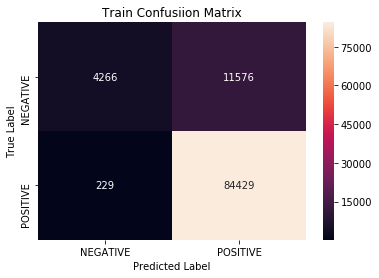

In [32]:
#ploting Confusion matrix
confusionmatrix(model,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Test Confusion Matrix

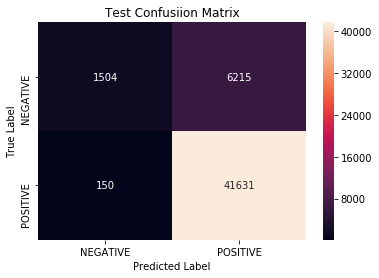

In [33]:
#ploting Confusion matrix
confusionmatrix(model,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 30 Most Important Features

In [29]:
important_features(vect,model)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		-5.902	also                          		-5.454	amazon
2.		-5.454	amazon                        		-5.523	bag
3.		-6.725	best                          		-5.328	box
4.		-5.013	buy                           		-5.013	buy
5.		-5.073	coffe                         		-5.073	coffe
6.		-5.248	dont                          		-5.580	disappoint
7.		-5.518	eat                           		-5.248	dont
8.		-6.094	find                          		-5.518	eat
9.		-4.759	flavor                        		-5.364	even
10.		-5.411	food                          		-4.759	flavor
11.		-5.130	get                           		-5.411	food
12.		-5.003	good                          		-5.130	get
13.		-5.903	great                         		-5.003	good
14.		-4.262	like                          		-4.262	like
15.		-5.996	littl               

#### Classification Report

In [28]:
print("Classification Report: \n")
y_pred=model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.92      0.19      0.31      7868
           1       0.87      1.00      0.93     41632

   micro avg       0.87      0.87      0.87     49500
   macro avg       0.89      0.59      0.62     49500
weighted avg       0.87      0.87      0.83     49500



### ComplimentNB()

#### Finding the best value of hyperparameter alpha

{'alpha': 0.05}
92.23250035319617


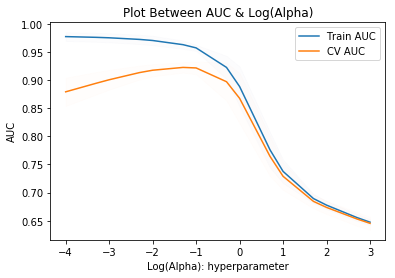

In [34]:
#select best parameter for ComplimentNB
model = ComplementNB()
gscv = findbestparameter(model,X_train_bow,y_train)
print(gscv.best_params_)
print(gscv.best_score_*100)
plot_auc(gscv)

#### Training the ComplimentNB model

In [35]:
#training the model using ComplimentNB
model = ComplementNB(alpha=gscv.best_params_['alpha'])
model.fit(X_train_bow,y_train)

ComplementNB(alpha=0.05, class_prior=None, fit_prior=True, norm=False)

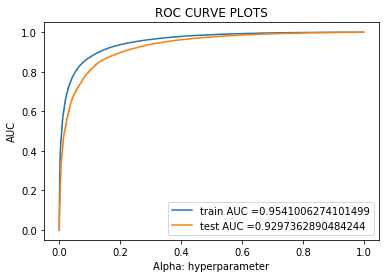

In [39]:
plot_auc_roc(model,X_train_bow,X_test_bow,y_train,y_test)

####  Confusion Matrices

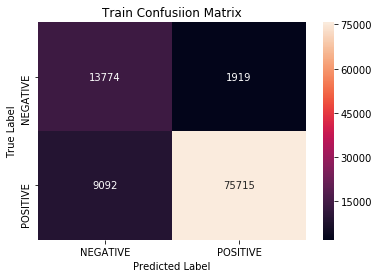

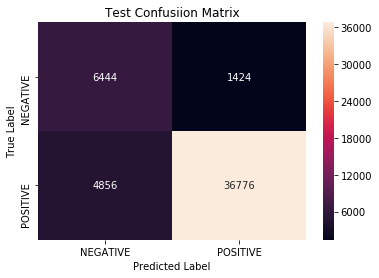

In [33]:
#ploting Confusion matrix
confusionmatrix(model,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#ploting Confusion matrix
confusionmatrix(model,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 30 Most Important Feature

In [35]:
important_features(vect,model)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		11.711	amoretti                      		15.930	artifc
2.		11.635	biscoff                       		15.930	artifi
3.		12.181	blu                           		15.930	artific
4.		12.067	camomil                       		15.930	bocar
5.		12.029	campus                        		15.930	boccaccio
6.		11.302	cobbler                       		15.930	cocco
7.		11.907	cous                          		15.930	cochin
8.		12.034	cutest                        		15.930	cocoaon
9.		11.947	hood                          		15.930	cocolibr
10.		12.236	kim                           		15.930	dingi
11.		12.132	melti                         		15.930	dingleberri
12.		12.022	memphi                        		15.930	gemaicha
13.		11.471	mmmmmm                        		15.930	gemelli
14.		11.702	mmmmmmm                       		15.930	halle

#### Classification Report

In [34]:
print("Classification Report: \n")
y_pred=model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.57      0.82      0.67      7868
           1       0.96      0.88      0.92     41632

   micro avg       0.87      0.87      0.87     49500
   macro avg       0.77      0.85      0.80     49500
weighted avg       0.90      0.87      0.88     49500



### Observations

1. ComplementNB is giving better results as compared to MultnomialNB
2. Words like good great like are important for possitive class while words like dissapoint , dont are important for negative class 

## TF-IDF

#### Vectorization of Review Text

In [16]:
vect = TfidfVectorizer(ngram_range=(1,2))
vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#### Fitting the vecorizer into train and test set

In [17]:
X_train_TFIDF = preprocessing.normalize(vect.transform(X_train))
X_test_TFIDF  = preprocessing.normalize(vect.transform(X_test))

In [17]:
print(X_train_TFIDF.shape,y_train.shape)
print(X_test_TFIDF.shape,y_test.shape)

(100500, 1270774) (100500,)
(49500, 1270774) (49500,)


#### Finding the best value of Hyperparameter Alpha

In [18]:
model = MultinomialNB()
gscv = findbestparameter(model,X_train_TFIDF,y_train)
print(gscv.best_params_)
print(gscv.best_score_*100)

{'alpha': 0.05}
89.79137906200218


#### Plotting AUC-Log(Alpha) curve

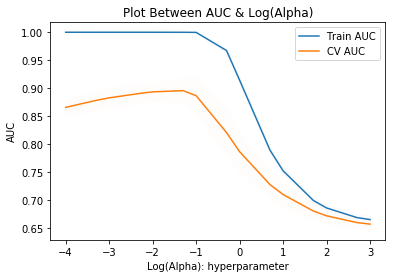

In [19]:
plot_auc(gscv)

#### Training the model with best value of Hyperparameter (Alpha)

In [19]:
#training the model
model = MultinomialNB(alpha=gscv.best_params_['alpha'])
model.fit(X_train_TFIDF,y_train)

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

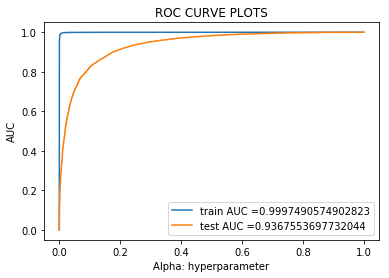

In [20]:
plot_auc_roc(model,X_train_TFIDF,X_test_TFIDF,y_train,y_test)

#### Finding the 30 most important features

In [21]:
important_features(vect,model)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		-7.391	amazon                        		-7.391	amazon
2.		-8.639	best                          		-7.362	bad
3.		-7.054	buy                           		-7.288	bag
4.		-6.900	coffe                         		-7.450	bought
5.		-7.425	dog                           		-7.159	box
6.		-7.737	drink                         		-7.054	buy
7.		-7.476	eat                           		-6.900	coffe
8.		-8.040	find                          		-7.187	disappoint
9.		-6.932	flavor                        		-7.425	dog
10.		-7.332	food                          		-7.191	dont
11.		-7.222	get                           		-7.476	eat
12.		-7.235	good                          		-7.310	even
13.		-8.085	great                         		-6.932	flavor
14.		-6.555	like                          		-7.332	food
15.		-7.975	littl              

#### Confusion Matrix

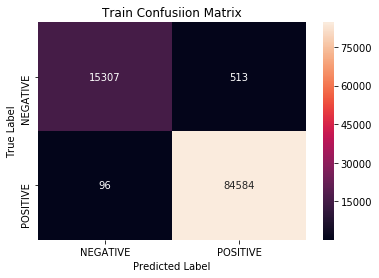

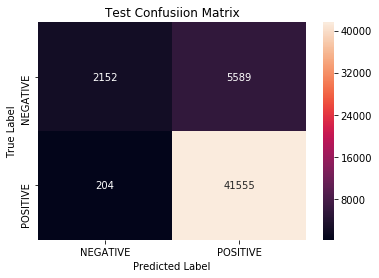

In [22]:
#ploting Confusion matrix
confusionmatrix(model,X_train_TFIDF,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#ploting Confusion matrix
confusionmatrix(model,X_test_TFIDF,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Classification Report

In [23]:
print("Classification Report: \n")
y_pred=model.predict(X_test_TFIDF)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.91      0.28      0.43      7741
           1       0.88      1.00      0.93     41759

   micro avg       0.88      0.88      0.88     49500
   macro avg       0.90      0.64      0.68     49500
weighted avg       0.89      0.88      0.86     49500



### ComplimentNB

#### Finding the best value of hyper-parameter (Alpha)

In [21]:
#select best parameter for ComplimentNB
model = ComplementNB()
gscv = findbestparameter(model,X_train_TFIDF,y_train)

#### Ploting AUC-Log(Alpha) Curve

{'alpha': 0.05}
89.57273712434917


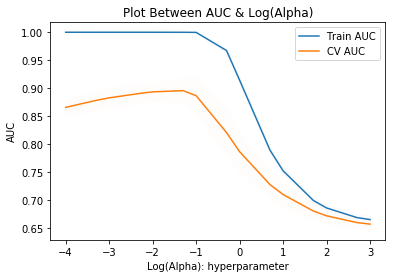

In [25]:
print(gscv.best_params_)
print(gscv.best_score_*100)
plot_auc(gscv)

#### Trining the model

In [22]:
#training the model
model = ComplementNB(alpha=gscv.best_params_['alpha'])
model.fit(X_train_TFIDF,y_train)

ComplementNB(alpha=0.05, class_prior=None, fit_prior=True, norm=False)

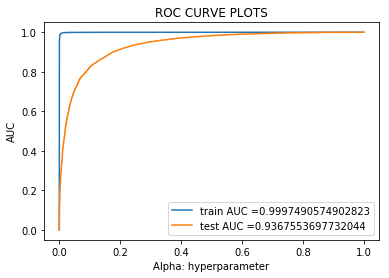

In [23]:
plot_auc_roc(model,X_train_TFIDF,X_test_TFIDF,y_train,y_test)

In [27]:
important_features(vect,model)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		12.438	alway need                    		16.392	allow return
2.		12.253	bake also                     		16.392	arriv stale
3.		12.701	better plus                   		16.392	away money
4.		12.589	cat come                      		16.392	box swiss
5.		11.673	crave sweet                   		16.392	box tablespoon
6.		12.694	crisp bread                   		16.392	box taco
7.		12.611	crunchi outsid                		16.392	box tad
8.		12.575	eas make                      		16.392	complet ined
9.		12.661	enjoy pasta                   		16.392	expir food
10.		12.233	everybodi love                		16.392	give zero
11.		12.510	fast free                     		16.392	let return
12.		12.350	fast fresh                    		16.392	maca research
13.		11.698	find love                     		16.392	maca strong
14.		12.04

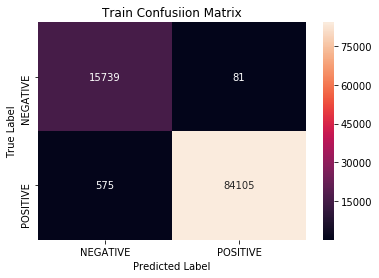

In [28]:
#ploting Confusion matrix
confusionmatrix(model,X_train_TFIDF,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

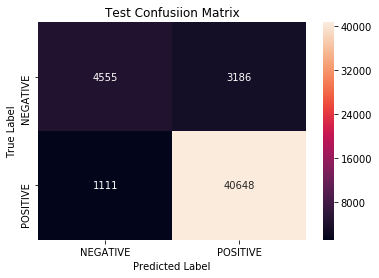

In [29]:
#ploting Confusion matrix
confusionmatrix(model,X_test_TFIDF,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
print("Classification Report: \n")
y_pred=model.predict(X_test_TFIDF)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      7741
           1       0.93      0.97      0.95     41759

   micro avg       0.91      0.91      0.91     49500
   macro avg       0.87      0.78      0.81     49500
weighted avg       0.91      0.91      0.91     49500



### Adding one more coloumn : length

In [20]:
Train_len=[]
Test_len=[]
for i in X_train:
    Train_len.append(len(i))
    
for i in X_test:
    Test_len.append(len(i))

Train_len=np.array(Train_len)
Test_len=np.array(Test_len)

Train_len=Train_len[:,np.newaxis]
Test_len=Test_len[:,np.newaxis]


<function matplotlib.pyplot.show(*args, **kw)>

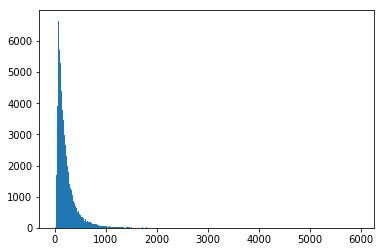

In [21]:
plt.hist(Train_len,bins = 500)
plt.show

## Bags of words

In [35]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [36]:
X_train_bow = preprocessing.normalize(vectorizer.transform(X_train))

In [18]:
print(X_train_bow.shape,y_train.shape)

(100500, 38301) (100500,)


In [37]:
X_train_bow=X_train_bow.todense()

In [38]:
X_train_bow=np.append(X_train_bow,Train_len,axis=1)
from scipy.sparse import csr_matrix
X_train_bow= csr_matrix(X_train_bow)

In [39]:
#select best parameter
model = ComplementNB()
gscv = findbestparameter(model,X_train_bow,y_train)
print(gscv.best_params_)
print(gscv.best_score_*100)
math.log10(0.05)

{'alpha': 0.05}
91.95109131728556


-1.3010299956639813

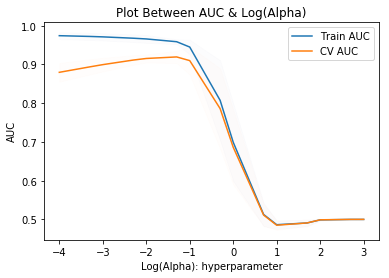

In [40]:
plot_auc(gscv)

In [41]:
#training the model using ComplimentNB
model = ComplementNB(alpha=gscv.best_params_['alpha'])
model.fit(X_train_bow,y_train)

ComplementNB(alpha=0.05, class_prior=None, fit_prior=True, norm=False)

In [ ]:
#ploting Confusion matrix
confusionmatrix(model,X_train_bow,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [43]:
X_test_bow = preprocessing.normalize(vectorizer.transform(X_test))

In [ ]:
print(X_test_bow.shape,y_test.shape)

In [44]:
X_test_bow=X_test_bow.todense()

In [45]:
X_test_bow=np.append(X_test_bow,Test_len,axis=1)
from scipy.sparse import csr_matrix
X_test_bow= csr_matrix(X_test_bow)

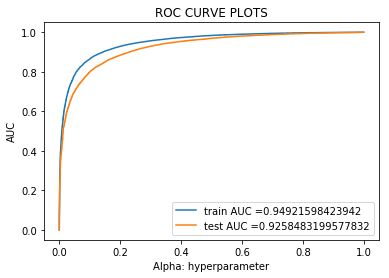

In [46]:
plot_auc_roc(model,X_train_bow,X_test_bow,y_train,y_test)

In [ ]:
#ploting Confusion matrix
confusionmatrix(model,X_test_bow,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print("Classification Report: \n")
y_pred=model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

In [ ]:
show_30_informative_feature(vectorizer,model)

### TF_IDF

In [16]:
vect = TfidfVectorizer()
vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
X_train_TFIDF = preprocessing.normalize(vect.transform(X_train))
print(X_train_TFIDF.shape,y_train.shape)

(100500, 38227) (100500,)


In [18]:
X_train_TFIDF=X_train_TFIDF.todense()

In [22]:
X_train_TFIDF = np.append(X_train_TFIDF,Train_len,axis=1)
from scipy.sparse import csr_matrix
X_train_TFIDF = csr_matrix(X_train_TFIDF)

In [23]:
#select best parameter
model = ComplementNB()
gscv = findbestparameter(model,X_train_TFIDF,y_train)
print(gscv.best_params_)
print(gscv.best_score_*100)
math.log10(0.05)

{'alpha': 0.05}
89.47735720082402


-1.3010299956639813

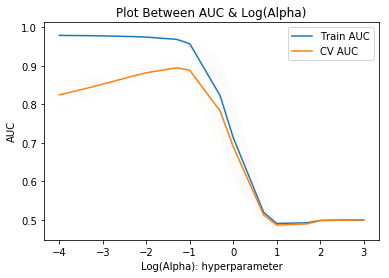

In [24]:
plot_auc(gscv)

In [25]:
#training the model using ComplimentNB
model = ComplementNB(alpha=gscv.best_params_['alpha'])
model.fit(X_train_TFIDF,y_train)

ComplementNB(alpha=0.05, class_prior=None, fit_prior=True, norm=False)

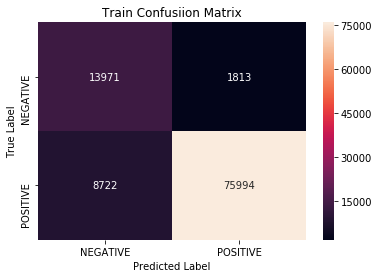

In [26]:
#ploting Confusion matrix
confusionmatrix(model,X_train_TFIDF,y_train)
plt.title("Train Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
X_test_TFIDF  = preprocessing.normalize(vect.transform(X_test))
print(X_test_TFIDF.shape,y_test.shape)

(49500, 38227) (49500,)


In [28]:
X_test_TFIDF=X_test_TFIDF.todense()

In [29]:
X_test_TFIDF = np.append(X_test_TFIDF,Test_len,axis=1)
from scipy.sparse import csr_matrix
X_test_TFIDF = csr_matrix(X_test_TFIDF)

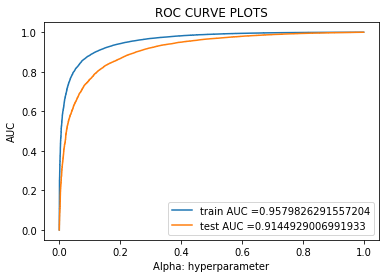

In [30]:
plot_auc_roc(model,X_train_TFIDF,X_test_TFIDF,y_train,y_test)

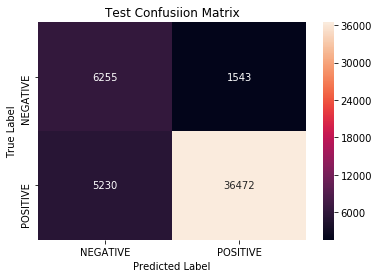

In [33]:
#ploting Confusion matrix
confusionmatrix(model,X_test_TFIDF,y_test)
plt.title("Test Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [34]:
print("Classification Report: \n")
y_pred=model.predict(X_test_TFIDF)
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.54      0.80      0.65      7798
           1       0.96      0.87      0.92     41702

   micro avg       0.86      0.86      0.86     49500
   macro avg       0.75      0.84      0.78     49500
weighted avg       0.89      0.86      0.87     49500



In [35]:
show_30_informative_feature(vect,model)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		15.935	arguabl                       		19.771	bostdistribut
2.		16.000	backcountri                   		19.771	botch
3.		15.852	branston                      		19.771	botswana
4.		15.680	camomil                       		19.771	bottler
5.		14.779	cerelac                       		19.771	botulinum
6.		16.053	conduc                        		19.771	discust
7.		15.337	cutest                        		19.771	eart
8.		15.931	gluton                        		19.771	earthbal
9.		15.282	glutten                       		19.771	earthen
10.		15.885	handbag                       		19.771	earthmat
11.		15.827	handel                        		19.771	earthshift
12.		16.076	handout                       		19.771	earthshiftproduct
13.		16.028	ingridi                       		19.771	earz
14.		15.853	jay                        

In [34]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Vectorizer", "Hyperparameter(Alpha)", "Train AUC","Test AUC","F1-Score"]
x.add_row(["MultinomialNB","BOW",0.05,0.95,0.92,0.83])
x.add_row(["MultinomialNB","TF-IDF",0.1,0.99,0.93,0.86])
x.add_row(["CompliementNB","BOW",0.05,0.95,0.93,0.88])
x.add_row(["CompliementNB","TF-IDF",0.1,0.99,0.93,0.91])

print(x)

+---------------+------------+-----------------------+-----------+----------+----------+
|     Model     | Vectorizer | Hyperparameter(Alpha) | Train AUC | Test AUC | F1-Score |
+---------------+------------+-----------------------+-----------+----------+----------+
| MultinomialNB |    BOW     |          0.05         |    0.95   |   0.92   |   0.83   |
| MultinomialNB |   TF-IDF   |          0.1          |    0.99   |   0.93   |   0.86   |
| CompliementNB |    BOW     |          0.05         |    0.95   |   0.93   |   0.88   |
| CompliementNB |   TF-IDF   |          0.1          |    0.99   |   0.93   |   0.91   |
+---------------+------------+-----------------------+-----------+----------+----------+


### After adding the length feature

In [33]:
x = PrettyTable()

x.field_names = ["Model","Vectorizer", "Hyperparameter(Alpha)", "Train AUC","Test AUC","F1-Score"]

x.add_row(["CompliementNB","BOW",0.05,0.95,0.93,0.88])
x.add_row(["CompliementNB","TF-IDF",0.1,0.95,0.91,0.87])

print(x)

+---------------+------------+-----------------------+-----------+----------+----------+
|     Model     | Vectorizer | Hyperparameter(Alpha) | Train AUC | Test AUC | F1-Score |
+---------------+------------+-----------------------+-----------+----------+----------+
| CompliementNB |    BOW     |          0.05         |    0.95   |   0.93   |   0.88   |
| CompliementNB |   TF-IDF   |          0.1          |    0.95   |   0.91   |   0.87   |
+---------------+------------+-----------------------+-----------+----------+----------+


# Takeaways

#### It is observed that ComplimentNB is outperforming NMultinomialNB
#### ComplimentNB is more suitable for Unbalanced datset like this
#### Words like good great like are important for possitive class while words like dissapoint , dont are important for negative class
#### Compared to KNN,Navive bayes has shown better performance in determining the polarity of the reviews.
#### Adding the length feature didn't improved the results
#### TF-IDF vectorizer has shown better results as compared to Bags of Words